In [13]:
import numpy as np
import math
import random

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import linear_model, datasets


# Plotter:---------------------------------------------------------
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5
#--------------(plotter)-------------------------------------------

[[ 8.86853985e-01 -7.38020631e-01]
 [-1.31860457e+00  1.41199178e+00]
 [ 5.64388835e-01  6.66597886e-01]
 [-5.68860827e-02 -1.03450211e+00]
 [-1.04170115e-01 -3.32824575e-02]
 [-4.21773731e-01 -4.55597024e-01]
 [-6.40261894e-01  5.72667200e-01]
 [-6.18107609e-01 -1.62649671e-01]
 [-1.19255879e+00  1.12759994e+00]
 [-1.25483235e+00  3.96966400e-01]
 [-1.31180875e+00  2.54525190e+00]
 [-7.89926198e-02  2.01460883e-01]
 [ 7.08702010e-01 -1.30656849e+00]
 [ 1.16585029e+00 -1.10924155e+00]
 [-7.83353198e-01  1.99802042e-01]
 [-5.07958664e-01  2.72617701e-01]
 [ 1.06249695e-01  1.02370914e-01]
 [ 1.96122721e+00 -1.04443449e+00]
 [ 1.50789074e+00 -1.44435937e+00]
 [ 1.05203219e+00 -5.58361318e-01]
 [-5.00630209e-01 -1.39342084e+00]
 [ 1.33058513e+00 -9.22743727e-01]
 [-5.55934007e-01 -7.58233589e-01]
 [-4.01097438e-01 -9.20968358e-01]
 [-5.52593305e-02 -2.61199297e-02]
 [ 1.17946166e+00 -1.15507513e+00]
 [-9.62998914e-01  6.16581494e-01]
 [ 1.95330710e+00 -8.25233427e-01]
 [-9.72718809e-01 -6

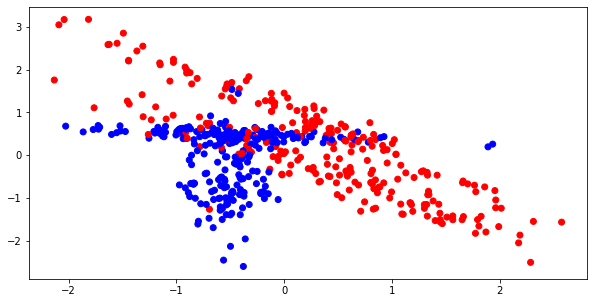

In [41]:

# Data set example:-------------------------------------------------------------------------
# n_samples int, default=100 The number of samples.
# n_features int, default=20 The total number of features. These comprise n_informative informative features, n_redundant redundant features, n_repeated duplicated features and n_features-n_informative-n_redundant-n_repeated useless features drawn at random.
# n_informative int, default=2 The number of informative features. Each class is composed of a number of gaussian clusters each located around the vertices of a hypercube in a subspace of dimension n_informative. For each cluster, informative features are drawn independently from N(0, 1) and then randomly linearly combined within each cluster in order to add covariance. The clusters are then placed on the vertices of the hypercube.
# n_redundant int, default=2 The number of redundant features. These features are generated as random linear combinations of the informative features.
# n_repeated int, default=0 The number of duplicated features, drawn randomly from the informative and the redundant features.
# n_classes int, default=2 The number of classes (or labels) of the classification problem.
# n_clusters_per_class int, default=2 The number of clusters per class.
# weights array-like of shape (n_classes,) or (n_classes - 1,), default=None The proportions of samples assigned to each class. If None, then classes are balanced. Note that if len(weights) == n_classes - 1, then the last class weight is automatically inferred. More than n_samples samples may be returned if the sum of weights exceeds 1. Note that the actual class proportions will not exactly match weights when flip_y isn’t 0.
# flip_y float, default=0.01 The fraction of samples whose class is assigned randomly. Larger values introduce noise in the labels and make the classification task harder. Note that the default setting flip_y > 0 might lead to less than n_classes in y in some cases.
# class_sep float, default=1.0 The factor multiplying the hypercube size. Larger values spread out the clusters/classes and make the classification task easier.
# hypercube bool, default=True If True, the clusters are put on the vertices of a hypercube. If False, the clusters are put on the vertices of a random polytope.
# shift float, ndarray of shape (n_features,) or None, default=0.0 Shift features by the specified value. If None, then features are shifted by a random value drawn in [-class_sep, class_sep].
# scale float, ndarray of shape (n_features,) or None, default=1.0 Multiply features by the specified value. If None, then features are scaled by a random value drawn in [1, 100]. Note that scaling happens after shifting.
# shuffle bool, default=True Shuffle the samples and the features.
# random_state int, RandomState instance or None, default=None Determines random number generation for dataset creation. Pass an int for reproducible output across multiple function calls. See Glossary.

# сгеренируем данные с помощью sklearn.datasets
X, Y = datasets.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    random_state=3,
    class_sep=0.5
)

colors = ListedColormap(['blue', 'red'])
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=colors);

#Qv,Qp = X.shape
#(Qv,Qp)

#print (X[:, 0])
#print (X[:, 1])
print (X)
print (Y)

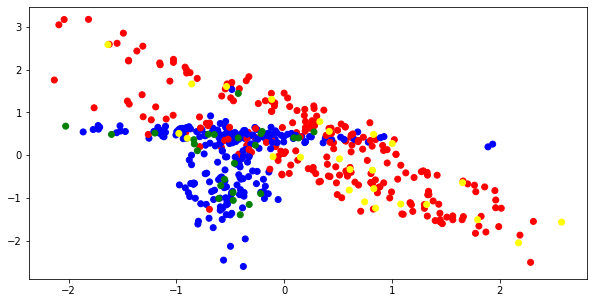

In [42]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.1,random_state=1)

colors = ListedColormap(['blue', 'red'])
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=colors);

colors = ListedColormap(['green', 'yellow'])
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=colors);

In [45]:


def max_min (any_array) : 
    max = np.amax(any_array)
    min = np.amin(any_array)
    return max,min


def split_by_value(X,threshold,target_column_index,Y):
    Qv,Qp = X.shape;
    left_x=[]; left_y=[]; right_x=[]; right_y=[];
    for j in range(0,Qv):
        if X[j][target_column_index]>=threshold :
            right_x.append(X[j]);
            right_y.append(Y[j]);
        else:
            left_x.append(X[j]);
            left_y.append(Y[j]);
    return np.array(left_x),np.array(right_x),np.array(left_y),np.array(right_y);


def sort_classes(y_vector):
    class_map = {};
    for element in y_vector:
        if element not in class_map: class_map[element] = []
        class_map[element].append(element);
    lengths = []
    for class_key in class_map: lengths.append(len(class_map[class_key]));
    return np.array(lengths);
            
    
class GiniIndex:
    
    def calculate (self,y_vector) :
        P = sort_classes(y_vector)/len(y_vector);
        xtr=0.0;
        for p_k in P: xtr+=p_k*(1-p_k);
        return xtr;

    
class ShenonIndex:
    
    def calculate (self,y_vector) :
        P = sort_classes(y_vector)/len(y_vector);
        xtr=0.0;
        for p_k in P: xtr-=p_k*self.log2(p_k);
        return xtr;
    
    def log2 (self,x_scalar):
        x=x_scalar;
        if(x_scalar==0): x=0.000000001;
        return np.log2(x);

    
class QualityCalculator:
    
    def __init__(self,index_calculator):
        self.index_calculator = index_calculator;
        
    def calculate(self,y_left,y_right,y_overall):
        overall = 1.0*len(y_overall);
        left = len(y_left);
        right = len(y_right);
        q_left = self.index_calculator.calculate(y_left);
        q_right = self.index_calculator.calculate(y_right);
        quality = self.index_calculator.calculate(y_overall) - q_left*left/overall - q_right*right/overall;
        return quality,q_left,q_right;


class Node :
    def __init__(self):
        self.prop_threshold = None;
        self.prop_index = None;
        self.left = None;
        self.right = None;
        self.values= None;
        
    def is_leaf(self) :
        return self.values is not None;
    
    def get_prediction(self,threshold_function) :
        avg = np.average(self.values);
        if threshold_function is not None:
            avg = threshold_function(avg);
        return avg;
    
    def select_right_left(self,x_vector) :
        if x_vector[self.prop_index]>=self.prop_threshold:
            return self.right;
        else:
            return self.left;

    def __str__(self):
        return "<<Node: t={},i={},left={},right={},values={}>>".format(self.prop_threshold,
                                                                   self.prop_index,self.left,self.right,self.values);
        
    
class GridElement:
    
    def __init__(self,index,threshold,permitted) :
        self.prop_index = index;
        self.prop_threshold = threshold;
        self.permitted = permitted;
        self.quality_value = 0.0;
        self.prop_left_values = [];
        self.prop_right_values = [];
        self.target_left_values = [];
        self.target_right_values = [];
        
    def __str__(self):
        return "GridElement: index={}, treshold={}, quality={}, permitted={}".format(self.prop_index,self.prop_threshold,
                                                                                     self.quality_value,
                                                                                    self.permitted);


# Special for the task 5:----------------------------------------------------------------------
# The special function for building randomized grid.    
def make_randomized_property_matrix_indexes(property_matrix):
    Qv,Qp = property_matrix.shape;
    
    matrix_columns = list(range(0,Qp));
    matrix_limit = int(np.round(np.sqrt(Qp)));
    matrix_limit = 1 if matrix_limit<=0 else matrix_limit;
    
    matrix_indexes = np.random.choice(matrix_columns, size=matrix_limit, replace=False);
    return matrix_indexes;

#-----------------------(special for the task 5)----------------------------------------------


# Special for the task 5:---------------------------------------------------------------------
def make_grid_elements (grid_size,property_matrix,random_option=False):
    
    Qv,Qp = property_matrix.shape;
    grid_elements = [];
    permitted_indexes=np.array(range(0,Qp));
    
    if random_option:
        permitted_indexes = make_randomized_property_matrix_indexes(property_matrix);
        
    print("Permitted indexes={}".format(permitted_indexes));
    
    for property_index in range (0,Qp):
        property_values = [];
        for vector_index in range (0,Qv):
            property_values.append(property_matrix[vector_index][property_index]);
        
        max,min = max_min(property_values);
        delta = np.abs((max-min)/grid_size);
        property_values = np.linspace(min-delta,max+delta, grid_size, endpoint=True);
        permitted=property_index in permitted_indexes;
        
        for property_value in property_values:
            grid_elements.append(GridElement(index=property_index,threshold=property_value,permitted=permitted));
    
    return grid_elements;
#---------------------(Special for the task 5)-------------------------------------------------


def calculate_grid_quality ( grid_elements, property_matrix, target_values, index_calculator ):
    quality_calculator = QualityCalculator(index_calculator);
    for grid_element in grid_elements:
        if grid_element.permitted:
            lx,rx,ly,ry=split_by_value( X=property_matrix, target_column_index=grid_element.prop_index,
                                   threshold=grid_element.prop_threshold, Y=target_values );
            q,ql,qr= quality_calculator.calculate( ly, ry, target_values );
            grid_element.quality_value = q;
            grid_element.target_left_values = ly;
            grid_element.target_right_values = ry;
            grid_element.prop_left_values = lx;
            grid_element.prop_right_values = rx;
    return grid_elements;


class RecursiveDepthCnt:
    def __init__(self):
        self.depth_map = {};
        
    def count_depth (self,prev_depth,element):
        if prev_depth not in self.depth_map:self.depth_map[prev_depth]=[];
        self.depth_map[prev_depth].append(element);
        prev_depth=prev_depth+1;
        return prev_depth;

class TreeBuildController:
    
    def __init__(self, single_class_per_leaf=True, max_depth=None, min_leaf_value_num=None):
        self.single_class_per_leaf = single_class_per_leaf;
        self.max_depth = max_depth;
        self.min_leaf_value_num = min_leaf_value_num;
        self.prop_limit = 2;
    
    def stop_splitting (self,prop_matrix,target_values,current_depth):
        control_cnt=0;
        #print ("Initial_property_matrix: {}".format(prop_matrix));
        control_cnt+=self.check_prop_matrix(prop_matrix);
        
        if self.single_class_per_leaf ==True and self.check_class_per_leaf(target_values):
            control_cnt+=1;
        if (self.max_depth is not None) and self.check_max_depth(current_depth):
            control_cnt+=1;
        if (self.min_leaf_value_num is not None) and self.check_leaf_values(target_values):
            control_cnt+=1;
        if control_cnt==0: print("   --> Splitting...");
        else: print("   --> Stop split control={}".format(control_cnt));
        return control_cnt>=1;
    
    def check_prop_matrix (self,prop_matrix):
        Qv,Qp = prop_matrix.shape;
        if Qv<self.prop_limit:
            print("______hard_learn_values: {}".format(prop_matrix))
            return 1;
        else:
            return 0;
        
    def check_class_per_leaf (self,target_values):
        class_array_lengths=sort_classes(target_values);
        if class_array_lengths.shape[0]>1:
            return False;
        else:
            print("______single_target: {}".format(target_values))
            return True;
    
    def check_max_depth (self, depth):
        if depth<self.max_depth:
            return False;
        else :
            print("______max_depth_achieve: {}".format(depth))
            return True;
        
    def check_leaf_values (self, target_values):
        if len(target_values)>=self.min_leaf_value_num:
            return False;
        else :
            print("______min_leaf_values: {}".format(target_values))
            return True;

class TreeFactory:
    def __init__(self,grid_size,index_calculator,controller):
        self.grid_size = grid_size;
        self.index_calculator = index_calculator;
        self.controller = controller;
    
    def make (self, property_matrix,target_values,random_option=False) :
        depth_cnt = RecursiveDepthCnt();
        return self.make_tree(property_matrix,target_values,depth_cnt,0,random_option);
    
    #
    # The method makes the tree and returns the main ROOT.
    # The tree is built according to the self.controller criteria
    # The quality is used to optimize the threshold and index search
    #
    def make_tree (self, property_matrix, target_values, depth_cnt, depth, random_option):
       
        if self.controller.stop_splitting(property_matrix,target_values,depth):
            return self.make_leaf(target_values);
        else :
            grid_elements = make_grid_elements( self.grid_size, property_matrix, random_option);
            grid_elements = calculate_grid_quality(grid_elements, property_matrix, target_values, self.index_calculator);
            best = sorted(grid_elements, reverse=True, key=lambda e : e.quality_value)[0];
            new_depth = depth_cnt.count_depth(depth,best.quality_value);
        
            print("   --> Selected grid element: {} {}->{}".format(best,depth,new_depth));
            
            local_root = self.make_root_node(best);
            local_root.left = self.make_tree(best.prop_left_values, best.target_left_values,
                                             depth_cnt, new_depth, random_option);
            local_root.right = self.make_tree(best.prop_right_values, best.target_right_values,
                                              depth_cnt, new_depth, random_option);
            return local_root;

    def make_root_node (self,grid_element):
        node = Node();
        node.prop_threshold = grid_element.prop_threshold;
        node.prop_index = grid_element.prop_index;
        print ("   --> Made node = {}".format(node));
        return node;
    
    def make_leaf (self,target_values):
        node = Node();
        node.values = target_values;
        print ("   --> Made leaf = {}".format(node));
        return node;
        
class Tree:
    def __init__(self):
        self.root_node = None;
        
    def fit(self,X,Y,grid_size=100,index_calculator=GiniIndex(),controller=TreeBuildController(),random_option=False):
        self.root_node= TreeFactory(grid_size=grid_size,index_calculator=index_calculator,controller =controller).make(X,Y,random_option);
        return self;
    
    def predict(self,x):
        predicted_values=[];
        for vector in x: predicted_values.append(self.predict_vector(vector,self.root_node));
        return np.array(predicted_values);
    
    def predict_vector(self,x_vector,any_root_node,threshold_function=None):
        if any_root_node.is_leaf():
            return any_root_node.get_prediction(threshold_function=lambda a: 1 if a>=0.5 else 0);
        else :
            next_node = any_root_node.select_right_left(x_vector);
            return self.predict_vector(x_vector,next_node);
        
# Special for the task-5:--------------------------------------------------------------------
class BootstrapForest:
    
    def __init__(self,tree_number=1):
        self.trees = [Tree() for i in range(0,tree_number)];
        
    def fit(self,X,Y,new_tree_size=1):
        if len(self.trees) != new_tree_size:
            self.trees = [Tree() for i in range(0,new_tree_size)];
        
        for tree in self.trees:
            bag_x,bag_y = self.make_bootstrap_bag(X,Y);
            tree.fit(X=bag_x,Y=bag_y,random_option=False)
        return self;
    
    def predict(self,property_matrix):
        results=[];
        for x_vector in property_matrix:
            results.append(self.predict_vector(x_vector));
        return np.array(results);
        
    def predict_vector(self,property_vector):
        results=[]
        for tree in self.trees:
            results.append(tree.predict_vector(property_vector,tree.root_node));
        result = self.calculate_results(results);
        return result;
        
    def make_bootstrap_bag(self,X,Y):
        Qv,Qp = X.shape
        rand_row_indexes = np.random.randint(0, Qv,size=Qv)
        #print("Bootstrap bag indexes: {}".format(rand_row_indexes));
        bag_x = X[rand_row_indexes];
        bag_y = Y[rand_row_indexes];
        return bag_x,bag_y;
    
    def calculate_results(self,y_vector):
        class_map = {};
        for element in y_vector:
            if element not in class_map: class_map[element] = 0
            class_map[element] = class_map[element]+1
        number=0;cnt=-1;
        for key in class_map:
            if cnt<class_map[key]: 
                number = key;
                cnt=class_map[key];
        return number;
#----------------(special for the task-5)-------------------------------------------------------        


In [46]:
forest = BootstrapForest().fit(x_train,y_train,5)

Bootstrap bag indexes: [374 360  39 427 252 195 423   2  43 298 387 180 449 114 315 330  25 338
 103 102 357 368 121 279 121  11 203  48 419 250 384 213 414 274 443 101
  41 290 434 442 398 168 190 136 354 181   7 206  70 123 398 114 382 416
 420  43 251 192 305 101  75 316 111  47 114 155  65 239 196 211 247 213
 132  44 119  69 212   6 121 358 360 104 194 123 227 252 132 158 370 423
 250 388 184 129 334 277 401 178 217 339  14 202 241  68 168 173 255 268
  62  55  86 102 339 277 418 252 122 359 116 391   6 438 213 165 102 375
 175   4 301 235 381 185  29 219 334 201 309  33 348 382  16 225 222 365
 325 185 302 309 169  53 345 142 301 224 348  84 276 434 425 249 204  10
 103 135  16 231 102 387 226  94 405 103  19 379 112 376  62 247  31 395
 207 225 260 407 125 149  92  83 267  35 311 145  21 381 293 335 266 185
 104 431 374 177 205 312 260 378 259 209 199 128  89 296 239 264 232  44
 195 320 346 228 190 353 255 103 255 282 407 194 424 381 418 187 438  22
  14 387 387 212  56 364 277

Initial_property_matrix: [[-5.07529818e-01  6.52230843e-01]
 [-1.15276994e+00  5.07170857e-01]
 [-5.09461757e-01 -1.02547744e+00]
 [-4.21773731e-01 -4.55597024e-01]
 [-6.40261894e-01  5.72667200e-01]
 [-8.59755426e-01 -2.21213223e-01]
 [-2.66437981e-01  6.23891463e-01]
 [-1.47399762e+00  5.53458758e-01]
 [-8.31994585e-01 -6.56169123e-01]
 [-3.57262492e-01  1.38835519e-01]
 [-1.75747927e-01 -7.23470655e-01]
 [-2.11452190e-01  5.36495500e-01]
 [-6.09339097e-01 -5.69154037e-01]
 [-5.93826162e-01  7.40483645e-01]
 [-5.93826162e-01  7.40483645e-01]
 [-4.46910168e-01  4.51366448e-01]
 [-2.17425644e-01 -8.64564823e-01]
 [-3.72582998e-01 -8.70202527e-01]
 [-6.67312733e-01  5.46155199e-01]
 [-7.33755107e-01 -4.32041551e-01]
 [-5.21002718e-01  3.74840535e-01]
 [-7.30862309e-01  2.33515763e-01]
 [-5.43433671e-01  7.88593802e-01]
 [-5.33173116e-01 -3.84882130e-02]
 [-4.31522460e-01 -8.65102616e-02]
 [-3.73879246e-01 -9.55528046e-01]
 [-5.07958664e-01  2.72617701e-01]
 [-1.26388222e-01  4.65105439e

   --> Selected grid element: GridElement: index=0, treshold=-0.6941515060797183, quality=0.4444444444444445 6->7
Made node= <<Node: t=-0.6941515060797183,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.69415182 -1.26144011]]
______hard_learn_values: [[-0.69415182 -1.26144011]]
______single_target: [1]
   --> Stop split control=2
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1]>>
Initial_property_matrix: [[-0.69312778 -0.62198332]
 [-0.69312778 -0.62198332]]
______single_target: [0 0]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[0 0]>>
Initial_property_matrix: [[-0.50946176 -1.02547744]
 [-0.42177373 -0.45559702]
 [-0.17574793 -0.72347066]
 [-0.6093391  -0.56915404]
 [-0.21742564 -0.86456482]
 [-0.372583   -0.87020253]
 [-0.43152246 -0.08651026]
 [-0.37387925 -0.95552805]
 [-0.49893639 -2.12535895]
 [-0.19370205 -0.56130558]
 [-0.58086332 -0.50673939]
 [-0.59255411 -0.523204  ]
 [-0.40662249 -0.80170683]


   --> Selected grid element: GridElement: index=1, treshold=0.5300749448716112, quality=0.0007823129251700277 7->8
Made node= <<Node: t=0.5300749448716112,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-1.15276994  0.50717086]
 [-0.44691017  0.45136645]
 [-0.12638822  0.46510544]
 [-0.13319849  0.45157302]
 [-0.60469508  0.40431412]
 [-0.73550164  0.45661837]
 [-1.15276994  0.50717086]
 [-0.45776296  0.5298416 ]
 [-1.25483235  0.3969664 ]
 [-0.14294741  0.517871  ]
 [-0.45776296  0.5298416 ]
 [-0.32168361  0.44546399]
 [-0.78426569  0.43240346]
 [-0.73314571  0.45418073]
 [-0.11929439  0.47922088]
 [-0.49408098  0.51217744]
 [-0.78426569  0.43240346]
 [-0.73550164  0.45661837]
 [-0.39536733  0.50995782]
 [-0.73314571  0.45418073]
 [-0.29100878  0.47209912]
 [-1.12902499  0.44846253]
 [-0.13319849  0.45157302]
 [-0.12638822  0.46510544]
 [-0.73314571  0.45418073]
 [-0.73550164  0.45661837]
 [-0.73305393  0.48449509]
 [-0.73550164  0.45661837]
 [-0.60469508  0.4043141

   --> Selected grid element: GridElement: index=1, treshold=0.4672708162017551, quality=0.17718750000000005 2->3
Made node= <<Node: t=0.4672708162017551,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.00505999  0.31021035]
 [ 0.61759063  0.42389677]
 [ 0.91242584  0.22783197]
 [ 0.57069749  0.32841265]
 [ 0.92483652  0.4345747 ]
 [ 0.62491019  0.41804275]
 [ 0.61759063  0.42389677]
 [ 0.08361216  0.38961887]
 [ 0.62491019  0.41804275]
 [ 0.61759063  0.42389677]
 [ 0.81478721  0.21164996]
 [ 0.64942552  0.3710548 ]
 [ 0.36049664  0.28947111]
 [ 0.5229585   0.42100433]
 [ 0.14967881  0.43393228]
 [ 0.38035984  0.39551918]
 [ 0.18977367  0.29378766]
 [ 0.23475721  0.43682427]
 [ 0.56227465  0.34403649]
 [ 1.88935931  0.19558878]
 [ 0.73327995  0.41999739]
 [ 0.57069749  0.32841265]
 [ 0.57069749  0.32841265]
 [ 0.38035984  0.39551918]
 [-0.00450319  0.43129832]
 [ 0.45643975  0.29282812]
 [ 0.19777863  0.31636369]
 [ 1.93261775  0.25921648]
 [ 0.57069749  0.32841265]

   --> Selected grid element: GridElement: index=1, treshold=0.717959766066167, quality=0.08900400025618967 0->1
Made node= <<Node: t=0.717959766066167,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-3.46723460e-01  3.89845850e-01]
 [ 9.53649510e-01  1.29858747e-01]
 [ 2.50801347e-01  4.27611151e-01]
 [ 1.80513698e+00 -1.65269718e+00]
 [-4.01097438e-01 -9.20968358e-01]
 [ 8.14787213e-01  2.11649964e-01]
 [-3.82358817e-01 -5.47445995e-01]
 [ 3.04861742e-02  4.89345525e-01]
 [ 7.33279948e-01  4.19997388e-01]
 [-1.42947415e-01  5.17871001e-01]
 [-3.02057701e-03  3.84833858e-02]
 [-5.93229453e-01 -1.20387626e+00]
 [-3.31195067e-01 -4.99669725e-01]
 [ 9.22375014e-01 -6.45112233e-01]
 [-1.77228331e+00  5.99683324e-01]
 [-4.06622485e-01 -8.01706829e-01]
 [-6.88682590e-01  2.81361289e-01]
 [-6.55297917e-01 -1.03401715e+00]
 [ 1.44610463e+00 -1.50290136e+00]
 [-3.43777706e-01  4.89681671e-01]
 [ 7.79007177e-01  3.04870516e-01]
 [ 1.08074545e+00 -2.33450484e-01]
 [ 2.28432954e

Made node= <<Node: t=-0.8472150062616188,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.40109744 -0.92096836]
 [-0.65529792 -1.03401715]
 [-0.37387925 -0.95552805]
 [-0.19236716 -0.84740004]
 [-0.88956921 -0.87344588]
 [-0.82531064 -1.00396142]
 [-0.18438674 -1.01145327]
 [-0.41472753 -0.91837447]
 [-0.18438674 -1.01145327]
 [-0.48794948 -0.86827416]
 [-0.59633167 -1.00047558]
 [-0.50946176 -1.02547744]
 [-0.37387925 -0.95552805]
 [-0.82531064 -1.00396142]
 [-0.53154894 -1.07875823]
 [-0.54369492 -0.99241866]
 [-0.88956921 -0.87344588]
 [-0.19236716 -0.84740004]
 [-0.372583   -0.87020253]
 [-0.19236716 -0.84740004]]
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]>>
Initial_property_matrix: [[ 9.53649510e-01  1.29858747e-01]
 [ 8.14787213e-01  2.11649964e-01]
 [-3.82358817e-01 -5.47445995e-01]
 [-3.02057701e-03  3.8483385

   --> Selected grid element: GridElement: index=1, treshold=0.19560178697313452, quality=0.5 7->8
Made node= <<Node: t=0.19560178697313452,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[1.88935931 0.19558878]
 [1.88935931 0.19558878]]
______single_target: [0 0]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[0 0]>>
Initial_property_matrix: [[0.81478721 0.21164996]
 [0.62798962 0.23851768]]
______single_target: [1 1]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1 1]>>
Initial_property_matrix: [[-0.34672346  0.38984585]
 [ 0.25080135  0.42761115]
 [ 0.03048617  0.48934552]
 [ 0.73327995  0.41999739]
 [-0.14294741  0.517871  ]
 [-1.77228331  0.59968332]
 [-0.68868259  0.28136129]
 [-0.34377771  0.48968167]
 [ 0.77900718  0.30487052]
 [-0.12638822  0.46510544]
 [-0.45243779  0.51210547]
 [-0.27287422  0.64850278]
 [-0.88378168  0.66539026]
 [-0.27287422  0.64850278]
 [-0.68868259  0.2

   --> Selected grid element: GridElement: index=0, treshold=-0.5177817245915713, quality=0.1261090909090909 8->9
Made node= <<Node: t=-0.5177817245915713,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.52100272  0.37484053]
 [-0.52100272  0.37484053]
 [-0.5522971   0.34734058]]
______single_target: [1 1 1]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1 1 1]>>
Initial_property_matrix: [[-0.34672346  0.38984585]
 [-0.06536088  0.29272458]
 [ 0.19777863  0.31636369]
 [-0.42133818  0.37250848]
 [-0.11641422  0.35208462]
 [-0.16689815  0.34397685]
 [ 0.43996199  0.36260551]
 [-0.34672346  0.38984585]
 [-0.11128082  0.2987987 ]
 [ 0.08361216  0.38961887]
 [-0.11641422  0.35208462]
 [-0.42133818  0.37250848]
 [-0.4535006   0.33435403]
 [ 0.5535353   0.37098375]
 [ 0.43996199  0.36260551]
 [-0.48034981  0.28970076]
 [-0.24498909  0.37369382]
 [ 0.45115045  0.28909951]
 [-0.11128082  0.2987987 ]
 [ 0.5535353   0.37098375]
 [-0.0

 [-1.72662035  0.69315311]]
   --> Splitting...
Permitted indexes=[1]
   --> Selected grid element: GridElement: index=1, treshold=0.6260532656647125, quality=0.033333333333333326 3->4
Made node= <<Node: t=0.6260532656647125,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[ 0.41493233  0.62564617]
 [-0.26643798  0.62389146]]
______single_target: [1 1]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1 1]>>
Initial_property_matrix: [[-0.27287422  0.64850278]
 [-0.88378168  0.66539026]
 [-0.27287422  0.64850278]
 [-0.27287422  0.64850278]
 [ 0.19631915  0.64814881]
 [ 0.56438883  0.66659789]
 [-1.72662035  0.69315311]
 [-0.54435637  0.65338737]
 [ 0.43370276  0.63372005]
 [-0.27287422  0.64850278]
 [-0.66139209  0.633034  ]
 [ 0.19631915  0.64814881]
 [ 0.56636477  0.6571984 ]
 [-0.01765179  0.64691518]
 [-0.66139209  0.633034  ]
 [ 0.28132611  0.6919907 ]
 [-1.52348553  0.68644791]
 [-0.50752982  0.65223084]
 [-0.66139209  0.6330

   --> Selected grid element: GridElement: index=1, treshold=0.7737071074798583, quality=0.0833584950029395 0->1
Made node= <<Node: t=0.7737071074798583,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[ 0.49447195  0.58219625]
 [-0.40662249 -0.80170683]
 [ 0.84499485 -0.57609434]
 [-0.43152246 -0.08651026]
 [ 0.52757671  0.72869078]
 [-0.18438674 -1.01145327]
 [-0.40662249 -0.80170683]
 [-0.5522971   0.34734058]
 [-0.45243779  0.51210547]
 [ 1.82552371 -1.42551679]
 [-0.79620867 -1.54028484]
 [-0.90584071  0.3910988 ]
 [-0.53274036  0.37638835]
 [-0.34824881  0.23197171]
 [ 0.57166214 -0.36714497]
 [-0.86756282 -0.66019381]
 [ 0.97818852 -0.99762575]
 [-0.73086231  0.23351576]
 [ 0.19343514  0.56172082]
 [-0.96299891  0.61658149]
 [-0.00505999  0.31021035]
 [ 1.66127728 -1.43220937]
 [ 1.96045624 -1.22589318]
 [ 1.76408497 -0.69934507]
 [-0.32747938  0.13578533]
 [ 0.08361216  0.38961887]
 [-0.02218816  0.04375787]
 [ 0.42482752  0.30149003]
 [-0.21145219  0.5364955 ]


   --> Selected grid element: GridElement: index=1, treshold=0.22081583862533805, quality=0.01881536054798144 1->2
Made node= <<Node: t=0.22081583862533805,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.40662249 -0.80170683]
 [ 0.84499485 -0.57609434]
 [-0.43152246 -0.08651026]
 [-0.18438674 -1.01145327]
 [-0.40662249 -0.80170683]
 [ 1.82552371 -1.42551679]
 [-0.79620867 -1.54028484]
 [ 0.57166214 -0.36714497]
 [-0.86756282 -0.66019381]
 [ 0.97818852 -0.99762575]
 [ 1.66127728 -1.43220937]
 [ 1.96045624 -1.22589318]
 [ 1.76408497 -0.69934507]
 [-0.32747938  0.13578533]
 [-0.02218816  0.04375787]
 [ 0.82565589 -1.25733001]
 [ 1.96122721 -1.04443449]
 [-0.41472753 -0.91837447]
 [ 0.81478721  0.21164996]
 [-0.71932547 -0.41819271]
 [-0.65930148 -1.69037915]
 [-0.69415182 -1.26144011]
 [-0.34094262 -0.16097204]
 [ 0.65533095 -0.6271628 ]
 [-0.5759189  -1.49896815]
 [-0.12659703  0.15081069]
 [ 0.49115631 -0.91897824]
 [-0.5759189  -1.49896815]
 [-0.40109744 -0.9209683

   --> Selected grid element: GridElement: index=0, treshold=-0.48570593183201904, quality=0.15779092702169623 8->9
Made node= <<Node: t=-0.48570593183201904,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.69415182 -1.26144011]
 [-0.50063021 -1.39342084]
 [-0.53849091 -1.38675057]]
   --> Splitting...
Permitted indexes=[0]
   --> Selected grid element: GridElement: index=0, treshold=-0.6940931734823474, quality=0.4444444444444445 9->10
Made node= <<Node: t=-0.6940931734823474,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.69415182 -1.26144011]]
______hard_learn_values: [[-0.69415182 -1.26144011]]
______single_target: [1]
   --> Stop split control=2
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1]>>
Initial_property_matrix: [[-0.50063021 -1.39342084]
 [-0.53849091 -1.38675057]]
______single_target: [0 0]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[0 0]>>
Initial_property_matrix: [[ 1

   --> Selected grid element: GridElement: index=0, treshold=-0.42124340102631264, quality=0.24489795918367352 7->8
Made node= <<Node: t=-0.42124340102631264,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.42177373 -0.45559702]]
______hard_learn_values: [[-0.42177373 -0.45559702]]
______single_target: [0]
   --> Stop split control=2
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[0]>>
Initial_property_matrix: [[ 1.32831619 -0.46453068]
 [ 0.58115047 -0.43179392]
 [ 1.32831619 -0.46453068]
 [ 1.32831619 -0.46453068]
 [ 0.0459646  -0.42426529]
 [ 0.80396718 -0.42858443]]
______single_target: [1 1 1 1 1 1]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1 1 1 1 1 1]>>
Initial_property_matrix: [[-0.71932547 -0.41819271]
 [-0.71932547 -0.41819271]
 [-0.71932547 -0.41819271]
 [-0.29381058 -0.36773129]
 [ 1.32479959 -0.39984837]]
   --> Splitting...
Permitted indexes=[1]
   --> Selected grid element: GridElement: ind

Made node= <<Node: t=0.622022491804236,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[ 0.49447195  0.58219625]
 [-0.5522971   0.34734058]
 [-0.45243779  0.51210547]
 [-0.90584071  0.3910988 ]
 [-0.53274036  0.37638835]
 [-0.34824881  0.23197171]
 [-0.73086231  0.23351576]
 [ 0.19343514  0.56172082]
 [-0.96299891  0.61658149]
 [-0.00505999  0.31021035]
 [ 0.08361216  0.38961887]
 [ 0.42482752  0.30149003]
 [-0.21145219  0.5364955 ]
 [-0.06536088  0.29272458]
 [-1.25483235  0.3969664 ]
 [-0.34672346  0.38984585]
 [ 0.43729148  0.50514986]
 [-0.50795866  0.2726177 ]
 [-0.50098048  0.39168571]
 [-0.50098048  0.39168571]
 [-1.55462382  0.52543177]
 [ 0.38035984  0.39551918]
 [-0.44988582  0.31789811]
 [-0.45776296  0.5298416 ]
 [ 0.12091786  0.4205101 ]
 [-0.57697454  0.46892749]
 [ 0.38816871  0.46218931]
 [ 0.84688042  0.36489036]
 [ 0.89162049  0.40901452]
 [-0.4535006   0.33435403]
 [ 0.4243239   0.52278241]
 [-0.00450319  0.43129832]
 [-1.47399762  0.55345876]
 [-0.5

   --> Splitting...
Permitted indexes=[1]
   --> Selected grid element: GridElement: index=1, treshold=0.3055399254843388, quality=0.03214285714285714 8->9
Made node= <<Node: t=0.3055399254843388,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[0.42482752 0.30149003]
 [0.45115045 0.28909951]
 [0.77900718 0.30487052]
 [0.91242584 0.22783197]
 [1.93261775 0.25921648]]
   --> Splitting...
Permitted indexes=[1]
   --> Selected grid element: GridElement: index=1, treshold=0.3016722494903387, quality=0.18 9->10
Made node= <<Node: t=0.3016722494903387,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[0.42482752 0.30149003]
 [0.45115045 0.28909951]
 [0.91242584 0.22783197]
 [1.93261775 0.25921648]]
   --> Splitting...
Permitted indexes=[0]
   --> Selected grid element: GridElement: index=0, treshold=0.9223982970490276, quality=0.375 10->11
Made node= <<Node: t=0.9223982970490276,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[0.42482752 0.3014

   --> Selected grid element: GridElement: index=0, treshold=-0.4975091376613507, quality=0.11111111111111116 3->4
Made node= <<Node: t=-0.4975091376613507,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.49755305  1.61889942]
 [-0.49755305  1.61889942]]
______single_target: [1 1]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1 1]>>
Initial_property_matrix: [[-0.416751    1.55218659]
 [-0.48553443  1.53448536]
 [-0.35265221  1.73932997]
 [-0.48553443  1.53448536]]
   --> Splitting...
Permitted indexes=[1]
   --> Selected grid element: GridElement: index=1, treshold=1.5345474332320943, quality=0.5 4->5
Made node= <<Node: t=1.5345474332320943,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.48553443  1.53448536]
 [-0.48553443  1.53448536]]
______single_target: [0 0]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[0 0]>>
Initial_property_matrix: [[-0.416751    1.55

   --> Selected grid element: GridElement: index=0, treshold=-0.03108244337893562, quality=0.2701085506915077 1->2
Made node= <<Node: t=-0.03108244337893562,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.29381058 -0.36773129]
 [-0.73086231  0.23351576]
 [-0.50752982  0.65223084]
 [-0.23407827  0.16007488]
 [-0.24498909  0.37369382]
 [-0.34672346  0.38984585]
 [-0.54435637  0.65338737]
 [-0.80146115 -1.60655337]
 [-0.42133818  0.37250848]
 [-0.53317312 -0.03848821]
 [-0.88378168  0.66539026]
 [-0.7833532   0.19980204]
 [-0.06859431  0.5199299 ]
 [-0.32747938  0.13578533]
 [-0.03208758  0.09472898]
 [-0.36971061  0.39462434]
 [-0.27287422  0.64850278]
 [-0.69776821 -1.47071722]
 [-0.33119507 -0.49966972]
 [-0.61573404  0.54805156]
 [-0.17574793 -0.72347066]
 [-0.54968019 -0.34201067]
 [-0.45243779  0.51210547]
 [-1.10170782  0.53598281]
 [-0.90584071  0.3910988 ]
 [-0.65930148 -1.69037915]
 [-0.5972963   0.24091818]
 [-0.91322979  0.53490155]
 [-1.00485888  0.472002

   --> Selected grid element: GridElement: index=1, treshold=0.2398130812106279, quality=0.030753739385861012 4->5
Made node= <<Node: t=0.2398130812106279,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.73086231  0.23351576]
 [-0.23407827  0.16007488]
 [-0.53317312 -0.03848821]
 [-0.7833532   0.19980204]
 [-0.32747938  0.13578533]
 [-0.34824881  0.23197171]
 [-0.05525933 -0.02611993]
 [-0.39038275  0.04300527]
 [-0.30447741  0.06998577]
 [-0.45551882 -0.04327408]
 [-0.57373624  0.10788405]
 [-0.53317312 -0.03848821]
 [-0.5453216  -0.03839344]
 [-0.57520307  0.09639682]
 [-0.39038275  0.04300527]
 [-0.73086231  0.23351576]
 [-0.32189955  0.00969832]
 [-0.30447741  0.06998577]
 [-0.3788205  -0.01887709]
 [-0.32189955  0.00969832]
 [-0.58296978  0.1839915 ]
 [-0.32668336 -0.03779539]
 [-0.39038275  0.04300527]
 [-0.05525933 -0.02611993]
 [-0.7833532   0.19980204]
 [-0.3788205  -0.01887709]
 [-0.3788205  -0.01887709]
 [-0.32189955  0.00969832]
 [-0.32668336 -0.03779539

 [-0.42133818  0.37250848]]
   --> Splitting...
Permitted indexes=[1]
   --> Selected grid element: GridElement: index=1, treshold=0.38231984617673104, quality=0.06055450535601767 8->9
Made node= <<Node: t=0.38231984617673104,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.24498909  0.37369382]
 [-0.42133818  0.37250848]
 [-0.5972963   0.24091818]
 [-0.11128082  0.2987987 ]
 [-0.06536088  0.29272458]
 [-0.44988582  0.31789811]
 [-0.4535006   0.33435403]
 [-0.48034981  0.28970076]
 [-0.44988582  0.31789811]
 [-0.59757311  0.28116037]
 [-0.11641422  0.35208462]
 [-0.16611456  0.29887493]
 [-0.59757311  0.28116037]
 [-0.08490123  0.37282995]
 [-0.16611456  0.29887493]
 [-0.68868259  0.28136129]
 [-0.26772635  0.38091127]
 [-0.16689815  0.34397685]
 [-0.30995035  0.26261402]
 [-0.42133818  0.37250848]]
   --> Splitting...
Permitted indexes=[0]
   --> Selected grid element: GridElement: index=0, treshold=-0.2389465331517679, quality=0.08357142857142857 9->10
Made node= 

   --> Selected grid element: GridElement: index=0, treshold=-0.01752881888460741, quality=0.06722222222222224 4->5
Made node= <<Node: t=-0.01752881888460741,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.01765179  0.64691518]
 [-0.01765179  0.64691518]]
______single_target: [1 1]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1 1]>>
Initial_property_matrix: [[ 0.38035984  0.39551918]
 [ 0.18977367  0.29378766]
 [ 0.10714986  0.46174723]
 [ 0.38816871  0.46218931]
 [ 0.06617476  0.5096343 ]
 [ 0.36049664  0.28947111]
 [ 0.03048617  0.48934552]
 [ 0.19777863  0.31636369]
 [ 0.18977367  0.29378766]
 [-0.00505999  0.31021035]
 [ 0.19631915  0.64814881]
 [ 0.03048617  0.48934552]
 [ 0.19777863  0.31636369]
 [ 0.19343514  0.56172082]
 [ 0.14967881  0.43393228]
 [ 0.19614193  0.78752047]
 [ 0.1138763   0.52868073]
 [ 0.19343514  0.56172082]]
   --> Splitting...
Permitted indexes=[1]
   --> Selected grid element: GridElement: in

   --> Selected grid element: GridElement: index=0, treshold=-0.47947692541201853, quality=0.0546875 2->3
Made node= <<Node: t=-0.47947692541201853,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.49755305  1.61889942]
 [-0.48553443  1.53448536]
 [-0.49633815  1.33919106]
 [-0.48553443  1.53448536]]
   --> Splitting...
Permitted indexes=[0]
   --> Selected grid element: GridElement: index=0, treshold=-0.4963111228555256, quality=0.5 3->4
Made node= <<Node: t=-0.4963111228555256,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.49755305  1.61889942]
 [-0.49633815  1.33919106]]
______single_target: [1 1]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1 1]>>
Initial_property_matrix: [[-0.48553443  1.53448536]
 [-0.48553443  1.53448536]]
______single_target: [0 0]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[0 0]>>
Initial_property_matrix: [[ 1.85900530e-01  9.3015

Initial_property_matrix: [[ 2.18586830e+00 -1.86394078e+00]
 [-7.74837141e-01 -1.13205992e+00]
 [ 1.62876625e-01  4.36697349e-01]
 [ 1.85878576e+00 -7.39560030e-01]
 [-1.84386743e-01 -1.01145327e+00]
 [-8.31994585e-01 -6.56169123e-01]
 [-2.44989090e-01  3.73693816e-01]
 [-5.93229453e-01 -1.20387626e+00]
 [-1.17248240e+00  6.51790006e-01]
 [-1.55462382e+00  5.25431775e-01]
 [ 1.29934846e+00 -1.23852477e+00]
 [ 4.24827521e-01  3.01490033e-01]
 [-2.51354702e-01 -3.77326317e-01]
 [-5.92554112e-01 -5.23203996e-01]
 [-3.73879246e-01 -9.55528046e-01]
 [-5.43433671e-01  7.88593802e-01]
 [-6.67312733e-01  5.46155199e-01]
 [ 1.09048028e+00 -1.37049559e+00]
 [-5.00630209e-01 -1.39342084e+00]
 [-2.34078272e-01  1.60074875e-01]
 [ 1.16585029e+00 -1.10924155e+00]
 [-4.01097438e-01 -9.20968358e-01]
 [-5.98512164e-01  2.61224491e-01]
 [-3.96428241e-01 -8.51598753e-02]
 [-4.98936394e-01 -2.12535895e+00]
 [-1.93702054e-01 -5.61305579e-01]
 [-5.43433671e-01  7.88593802e-01]
 [-5.74237975e-01 -1.24552043e

 [-4.22181053e-01  2.54302278e-02]]
   --> Splitting...
Permitted indexes=[0]
   --> Selected grid element: GridElement: index=0, treshold=-0.3535115075089037, quality=0.005575019123295499 3->4
Made node= <<Node: t=-0.3535115075089037,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-7.74837141e-01 -1.13205992e+00]
 [-8.31994585e-01 -6.56169123e-01]
 [-5.93229453e-01 -1.20387626e+00]
 [-5.92554112e-01 -5.23203996e-01]
 [-3.73879246e-01 -9.55528046e-01]
 [-5.00630209e-01 -1.39342084e+00]
 [-4.01097438e-01 -9.20968358e-01]
 [-3.96428241e-01 -8.51598753e-02]
 [-4.98936394e-01 -2.12535895e+00]
 [-5.74237975e-01 -1.24552043e+00]
 [-6.97768208e-01 -1.47071722e+00]
 [-8.77172047e-01 -9.64232162e-01]
 [-3.96428241e-01 -8.51598753e-02]
 [-8.42559331e-01 -6.78764957e-01]
 [-8.59755426e-01 -2.21213223e-01]
 [-8.31994585e-01 -6.56169123e-01]
 [-3.79601391e-01 -2.59538762e+00]
 [-5.36992215e-01 -1.15927923e+00]
 [-8.01461145e-01 -1.60655337e+00]
 [-6.94151816e-01 -1.26144011e+00]
 

   --> Selected grid element: GridElement: index=0, treshold=-0.3311869705211838, quality=0.28125 5->6
Made node= <<Node: t=-0.3311869705211838,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.33119507 -0.49966972]
 [-0.33119507 -0.49966972]
 [-0.33119507 -0.49966972]
 [-0.33119507 -0.49966972]]
______single_target: [0 0 0 0]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[0 0 0 0]>>
Initial_property_matrix: [[-0.30447741  0.06998577]
 [-0.32668336 -0.03779539]
 [-0.32747938  0.13578533]
 [-0.32747938  0.13578533]]
   --> Splitting...
Permitted indexes=[1]
   --> Selected grid element: GridElement: index=1, treshold=-0.037742788671038224, quality=0.375 6->7
Made node= <<Node: t=-0.037742788671038224,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.32668336 -0.03779539]]
______hard_learn_values: [[-0.32668336 -0.03779539]]
______single_target: [0]
   --> Stop split control=2
Made leaf= <<Node: t=None,i=Non

 [-0.9127354   0.61127611]]
   --> Splitting...
Permitted indexes=[0]
   --> Selected grid element: GridElement: index=0, treshold=-0.3739595763173458, quality=0.009733511330415556 5->6
Made node= <<Node: t=-0.3739595763173458,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[-1.55462382  0.52543177]
 [-0.66731273  0.5461552 ]
 [-0.59851216  0.26122449]
 [-0.50098048  0.39168571]
 [-0.64026189  0.5726672 ]
 [-0.57078469  0.32716086]
 [-1.86512826  0.54379511]
 [-0.59757311  0.28116037]
 [-1.10170782  0.53598281]
 [-1.25483235  0.3969664 ]
 [-0.66731273  0.5461552 ]
 [-1.1482647   0.58260336]
 [-0.96299891  0.61658149]
 [-0.60469508  0.40431412]
 [-0.90584071  0.3910988 ]
 [-0.5522971   0.34734058]
 [-0.53453679  0.52867409]
 [-0.99694639  0.55082852]
 [-1.2613436   0.48428552]
 [-0.90584071  0.3910988 ]
 [-0.42133818  0.37250848]
 [-1.2613436   0.48428552]
 [-0.90584071  0.3910988 ]
 [-0.78426569  0.43240346]
 [-0.45776296  0.5298416 ]
 [-0.93887571  0.49792346]
 [-0.45

 [ 0.12091786  0.4205101 ]]
   --> Splitting...
Permitted indexes=[0]
   --> Selected grid element: GridElement: index=0, treshold=0.1986338708694509, quality=0.01518117451062062 7->8
Made node= <<Node: t=0.1986338708694509,i=0,left=None,right=None,values=None>>
Initial_property_matrix: [[ 0.16287662  0.43669735]
 [-0.24498909  0.37369382]
 [-0.02852754  0.4655155 ]
 [ 0.19343514  0.56172082]
 [-0.12638822  0.46510544]
 [-0.17196031  0.49624363]
 [-0.12638822  0.46510544]
 [-0.02852754  0.4655155 ]
 [-0.21179078  0.44172201]
 [-0.13319849  0.45157302]
 [ 0.14967881  0.43393228]
 [ 0.19343514  0.56172082]
 [ 0.10714986  0.46174723]
 [-0.13319849  0.45157302]
 [-0.11128082  0.2987987 ]
 [-0.11128082  0.2987987 ]
 [ 0.10714986  0.46174723]
 [ 0.19343514  0.56172082]
 [-0.12638822  0.46510544]
 [ 0.16287662  0.43669735]
 [ 0.18977367  0.29378766]
 [-0.02852754  0.4655155 ]
 [-0.12638822  0.46510544]
 [-0.13319849  0.45157302]
 [-0.14294741  0.517871  ]
 [-0.11641422  0.35208462]
 [ 0.14967

Permitted indexes=[1]
   --> Selected grid element: GridElement: index=1, treshold=0.6880042818848796, quality=0.08229851473094714 4->5
Made node= <<Node: t=0.6880042818848796,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-1.1724824   0.65179001]
 [-1.1724824   0.65179001]
 [-0.26643798  0.62389146]
 [-0.12265691  0.65208628]
 [-0.88378168  0.66539026]
 [-0.66139209  0.633034  ]
 [-0.26643798  0.62389146]
 [-1.10148654  0.67461212]
 [-0.50752982  0.65223084]
 [-1.52348553  0.68644791]
 [-1.10148654  0.67461212]
 [ 0.19631915  0.64814881]
 [-0.90778484  0.64458451]
 [ 0.56636477  0.6571984 ]
 [ 0.43370276  0.63372005]
 [ 0.56636477  0.6571984 ]
 [-0.27287422  0.64850278]
 [-0.77736341  0.63618383]
 [-0.50752982  0.65223084]
 [ 0.19631915  0.64814881]
 [-0.90778484  0.64458451]
 [-0.88378168  0.66539026]
 [-1.71204022  0.65425851]
 [-1.52348553  0.68644791]
 [-1.52348553  0.68644791]]
   --> Splitting...
Permitted indexes=[1]
   --> Selected grid element: GridElement:

   --> Selected grid element: GridElement: index=1, treshold=1.4506828093481636, quality=0.010712035286704447 2->3
Made node= <<Node: t=1.4506828093481636,i=1,left=None,right=None,values=None>>
Initial_property_matrix: [[-0.49633815  1.33919106]
 [ 0.03125324  1.33733964]
 [-0.09134901  1.15038504]
 [-0.00156328  1.44950588]
 [-0.11995579  1.44467796]
 [-0.49633815  1.33919106]
 [ 0.36695712  1.05292189]
 [ 0.25867607  0.80638617]
 [-0.09134901  1.15038504]
 [-0.08817754  1.22399401]
 [-0.24080827  1.2061868 ]
 [-0.09134901  1.15038504]
 [-0.00156328  1.44950588]
 [-0.11934317  1.02387588]
 [ 0.2767405   1.09053903]
 [-0.11988446  1.26025588]
 [-0.11988446  1.26025588]]
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
   --> Stop split control=1
Made leaf= <<Node: t=None,i=None,left=None,right=None,values=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]>>
Initial_property_matrix: [[-0.48553443  1.53448536]
 [-0.49755305  1.61889942]
 [-0.35265221  1.73932997]
 [-0.48666756  1.6984233 ]
 [-0

In [31]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

y_pred = forest.predict(x_test);

print('Precision {}'.format(precision_score(y_test,y_pred)))
print("Recall {}".format(recall_score(y_test,y_pred)))
print("F1 {}".format(f1_score(y_test,y_pred)))
fpr,tpr,thresholds = roc_curve(y_test,y_pred)


Precision 0.8734177215189873
Recall 0.8808510638297873
F1 0.8771186440677966
